# Splines

The following tutorial is based on an example from {cite:p}`James2021` and Python code from [Singh (2018)](https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/).

## Python setup

In [1]:
# import modules
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt 
%matplotlib inline

## Data import

In [2]:
# read data_set
df = pd.read_csv('https://raw.githubusercontent.com/kirenz/datasets/master/wage.csv')
df

,Unnamed: 0,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,376816,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,302281,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,10033,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,14375,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


In [3]:
# We only use the feature age to predict wage
x = df['age']
y = df['wage']

In [4]:
# Dividing data into train and test datasets
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.33, random_state = 1)

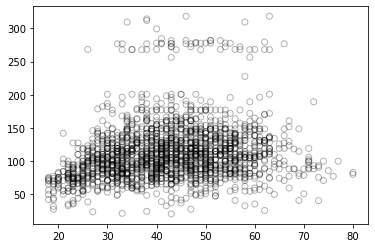

In [5]:
# Visualize the relationship b/w age and wage
import matplotlib.pyplot as plt
plt.scatter(train_x, train_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.show()

In [6]:
# prepare data shape for linear regression
x = train_x.values.reshape(-1,1)

## Simple regression

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x,train_y)

print(model.coef_)
print(model.intercept_)

[0.72190831]
80.65287741163839


## Polynomial regression

In [36]:
# Generating weights for polynomial function with degree =2
poly_2 = np.polyfit(train_x, train_y, 2)

print(poly_2)

[ -0.05194765   5.22868974 -10.03406116]


In [37]:
# Generating model with the given weights
model = np.poly1d(poly_2)

In [38]:
# Prediction on testation set
pred = model(test_x)

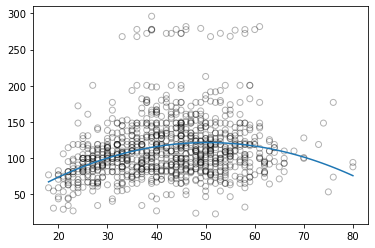

In [39]:
# We will plot the graph for 70 observations only
xp = np.linspace(test_x.min(),test_x.max(),70)

pred_plot = model(xp)

plt.scatter(test_x, test_y, 
            facecolor='None', 
            edgecolor='k', 
            alpha=0.3)

plt.plot(xp, pred_plot)
plt.show()

## Piecewise Step Functions

A step function is a function which remains constant within the interval. We can fit individual step functions to each of the divided portions in order to avoid imposing a global structure. 

Here we break the range of X into bins, and fit a different constant in each bin.

### Data preparation

In [12]:
# Dividing the data into 4 bins
df_cut, bins = pd.cut(train_x, 4, retbins=True, right=True)
df_cut.value_counts(sort=False)

(17.938, 33.5]    504
(33.5, 49.0]      941
(49.0, 64.5]      511
(64.5, 80.0]       54
Name: age, dtype: int64

In [13]:
df_steps = pd.concat([train_x, df_cut, train_y], keys=['age','age_cuts','wage'], axis=1)

# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_cut)
df_steps_dummies.head()

,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
1382,0,1,0,0
23,0,1,0,0
2140,0,0,1,0
1117,1,0,0,0
933,0,1,0,0


In [14]:
df_steps_dummies.columns = ['17.938-33.5','33.5-49','49-64.5','64.5-80'] 

### Fit model

In [15]:
# Fitting Generalised linear models
fit3 = sm.GLM(df_steps.wage, df_steps_dummies).fit()

In [16]:
# Binning testation set into same 4 bins
bin_mapping = np.digitize(test_x, bins) 
X_test = pd.get_dummies(bin_mapping)

In [17]:
# Removing any outliers
X_test = pd.get_dummies(bin_mapping).drop([5], axis=1)

In [18]:
# Prediction
pred2 = fit3.predict(X_test)

In [19]:
# Calculating RMSE
from sklearn.metrics import mean_squared_error 

rms = mean_squared_error(test_y, pred2, squared=False) 
print(round(rms,2))

39.99


### Plot

In [20]:
# We will plot the graph for 70 observations only
xp = np.linspace(test_x.min(),test_x.max()-1,70) 

bin_mapping = np.digitize(xp, bins) 

X_test_2 = pd.get_dummies(bin_mapping) 

pred2 = fit3.predict(X_test_2)

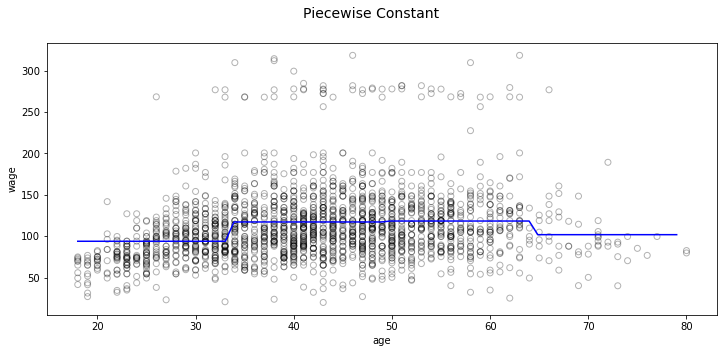

In [21]:
# Visualisation
fig, (ax1) = plt.subplots(1,1, figsize=(12,5))
fig.suptitle('Piecewise Constant', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(train_x, train_y, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(xp, pred2, c='b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
plt.show()

Binning has its obvious issues:

- most phenomena we study to vary continuously with inputs. 
- Binned regression does not create continuous functions of the predictor.

For example, in the above graph, we can see that the first bin clearly misses the increasing trend of wage with age.

## Basis functions

To capture non-linearity in regression models, we need to transform some, or all of the predictors. 

To avoid having to treat every predictor as linear, we want to apply a very general family of transformations to our predictors. 

The family should be flexible enough to adapt (when the model is fit) to a wide variety of shapes, but not too flexible as to over-fit.

This concept of a family of transformations that can fit together to capture general shapes is called a basis function.

## Piecewise Polynomials

Instead of fitting a constant function over different bins across the range of X, piecewise polynomial regression involves fitting separate low-degree polynomials over different regions of X. 

As we use lower degrees of polynomials, we don’t observe high oscillations of the curve around the data.

For example, a piecewise quadratic polynomial works by fitting a quadratic regression equation.

In other words, we fit two different polynomial functions to the data: one on the subset of the observations with $x_i$ < c, and one on the subset of the observations with $x_i$ ≥ c.

The first polynomial function has coefficients β01, β11, β21, β31 and the second has coefficients β02, β12, β22, β32. Each of these polynomial functions can be fit using the least squares error metric.

Remember that this family of polynomial functions has 8 degrees of freedom, 4 for each polynomial (as there are 4 variables).

Using more knots leads to a more flexible piecewise polynomial, as we use different functions for every bin. These functions depend only on the distribution of data of that particular bin. 

In general, if we place K different knots throughout the range of X, we will end up fitting K+1 different cubic polynomials. We can use any low degree polynomial to fit these individual bins. For example, we can instead fit piecewise linear functions. In fact, the stepwise functions used above are actually piecewise polynomials of degree 0.

Now we will look at some necessary conditions and constraints that should be followed while forming piecewise polynomials.

## Cubic splines

Cubic spline is a piecewise polynomial with a set of extra constraints (continuity, continuity of the first derivative, and continuity of the second derivative). 

In general, a cubic spline with K knots uses cubic spline with a total of 4 + K degrees of freedom. There is seldom any good reason to go beyond cubic-splines (unless one is interested in smooth derivatives).

In [22]:
from patsy import dmatrix
import statsmodels.api as sm

In [23]:
# Generating cubic spline with 3 knots at 25, 40 and 60
transformed_x = dmatrix("bs(train, knots=(25,40,60), degree=3, include_intercept=False)", 
                {"train": train_x},return_type='dataframe')

In [24]:
# Fitting Generalised linear model on transformed dataset
fit1 = sm.GLM(train_y, transformed_x).fit()

In [25]:
# Generating cubic spline with 4 knots
transformed_x2 = dmatrix("bs(train, knots=(25,40,50,65),degree=3, include_intercept=False)", 
                {"train": train_x}, return_type='dataframe')


In [26]:
# Fitting Generalised linear model on transformed dataset
fit2 = sm.GLM(train_y, transformed_x2).fit()

In [27]:
# Predictions on both splines
pred1 = fit1.predict(dmatrix("bs(test, knots=(25,40,60), include_intercept=False)", {"test": test_x}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(test, knots=(25,40,50,65),degree =3, include_intercept=False)", {"test": test_x}, return_type='dataframe'))

In [28]:
# Calculating RMSE values
rms1 = (mean_squared_error(test_y, pred1, squared=False))
print(rms1)

rms2 = (mean_squared_error(test_y, pred2, squared=False))
print(rms2)

39.40318768389144
39.34292609196197


### Plot

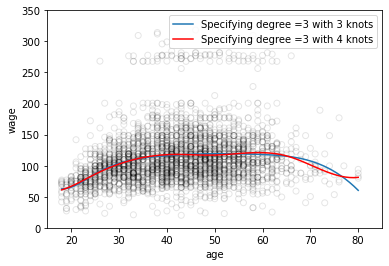

In [30]:

# We will plot the graph for 70 observations only
xp = np.linspace(test_x.min(),test_x.max(),70)

# Make some predictions
pred1 = fit1.predict(dmatrix("bs(xp, knots=(25,40,60), include_intercept=False)", {"xp": xp}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(xp, knots=(25,40,50,65),degree =3, include_intercept=False)", {"xp": xp}, return_type='dataframe'))

# Plot the splines and error bands
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred1, label='Specifying degree =3 with 3 knots')
plt.plot(xp, pred2, color='r', label='Specifying degree =3 with 4 knots')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

We know that the behavior of polynomials that are fit to the data tends to be erratic near the boundaries. Such variability can be dangerous. These problems are resembled by splines, too. The polynomials fit beyond the boundary knots behave even more wildly than the corresponding global polynomials in that region. To smooth the polynomial beyond the boundary knots, we will use a special type of spline known as Natural Spline.

## Natural cubic spline

A natural cubic spline adds additional constraints, namely that the function is linear beyond the boundary knots. 

This constrains the cubic and quadratic parts there to 0, each reducing the degrees of freedom by 2. That’s 2 degrees of freedom at each of the two ends of the curve, reducing K+4 to K.

In [31]:
# Generating natural cubic spline
transformed_x3 = dmatrix("cr(train,df = 3)", 
                {"train": train_x}, return_type='dataframe')

fit3 = sm.GLM(train_y, transformed_x3).fit()

In [32]:
# Prediction on test set
pred3 = fit3.predict(dmatrix("cr(test, df=3)", 
        {"test": test_x}, return_type='dataframe'))

In [34]:
# Calculating RMSE value
rms = mean_squared_error(test_y, pred3, squared=False)
print(rms)

39.448238138036565


### Plot

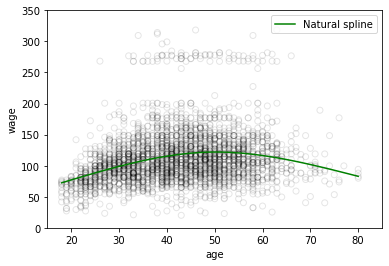

In [35]:
# We will plot the graph for 70 observations only
xp = np.linspace(test_x.min(),test_x.max(),70)
pred3 = fit3.predict(dmatrix("cr(xp, df=3)", {"xp": xp}, return_type='dataframe'))

# Plot the spline
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred3,color='g', label='Natural spline')

plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

### Number and Locations of Knots

When we fit a spline, where should we place the knots? One potential place would be the area of high variability, because in those regions the polynomial coefficients can change rapidly. Hence, one option is to place more knots in places where we feel the function might vary most rapidly, and to place fewer knots where it seems more stable.

While this option can work well, in practice it is common to place knots in a uniform fashion. One way to do this is to specify the desired degrees of freedom, and then have the software automatically place the corresponding number of knots at uniform quantiles of the data.

Another option is to try out different numbers of knots and see which produces the best looking curve.

## Cubic spline with scipy

<!--BOOK_INFORMATION-->

*This notebook contains an excerpt from the [Python Programming and Numerical Methods - A Guide for Engineers and Scientists](https://www.elsevier.com/books/python-programming-and-numerical-methods/kong/978-0-12-819549-9), the content is also available at [Berkeley Python Numerical Methods](https://pythonnumericalmethods.berkeley.edu/notebooks/Index.html).*

In [ ]:
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-poster')

In [ ]:
# make simple dataset
x = [0, 1, 2]
y = [1, 3, 2]

In [ ]:
# use bc_type = 'natural'
natural_spline = CubicSpline(x, y, bc_type='natural')

In [ ]:
x_new = np.linspace(0, 2, 100)
y_new = natural_spline(x_new)

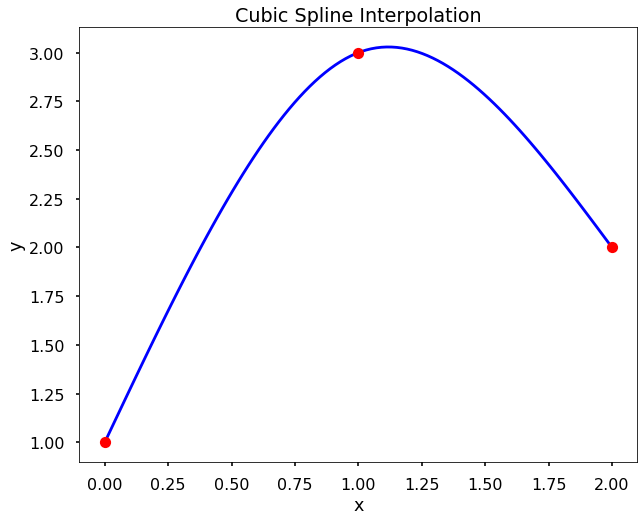

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(x_new, y_new, 'b')
plt.plot(x, y, 'ro')
plt.title('Cubic Spline Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()